In [1]:
#Imports
import os
import random
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

In [2]:
#Quick Plotting function
def plotting3D(x, y, z, text):
    fig = plt.figure(figsize = (13, 7))
    ax = fig.add_subplot(projection='3d') #


    surf = ax.plot_surface(x, y, z, cmap = cm.coolwarm,
    linewidth = 0, antialiased = False)

    #predict_surf = ax.plot_trisurf(x, y, zpredict, cmap = cm.coolwarm,
    #linewidth = 0, antialiased = False)
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(text, fontsize = 15)
    plt.show()

### Generating the data that we will work with:

In [3]:
#MSE and R2
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [4]:
#Franke function:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [5]:
#Function that creates design matrix for Franke's function
def create_X(x, y, n): #design matrices for polynomials up to 10th degree
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    #print(f'Features/Length beta: {l}') #what amount should we expect?
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

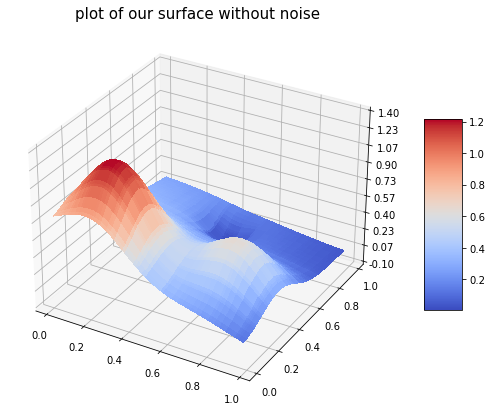

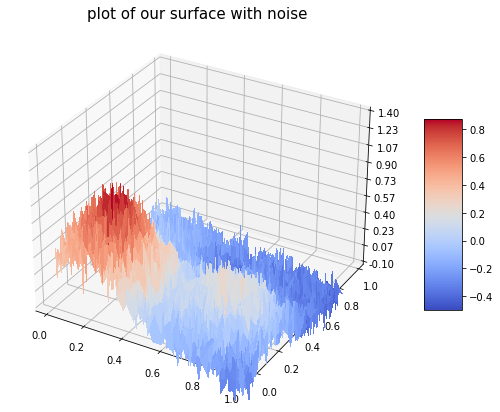

In [14]:
#Generating the datapoints:
N = 100
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

#And for the noice:
var = 0.1 #variance of noise (?)
noise = np.random.normal(0, var, len(x_)*len(x_))
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_)
z_noise =  FrankeFunction(x_, y_) + noise 


def scaling(z):
    z_flat = np.ravel(z)
    mean = np.mean(z_flat)
    std = np.std(z_flat)
    #z_flat = (z_flat - mean)/stdd
    for i in range(len(z_flat)):
        z_flat[i] = (z_flat[i] - mean)#/std
    return z_flat

z_new = scaling(z_noise)


plotting3D(x_, y_, z, "plot of our surface without noise")
plotting3D(x_, y_, z_noise, "plot of our surface with noise")

### Standard OLS-regression and evaluation of error

In [7]:
X = create_X(x_, y_, n = 5)
# We split the data in test and training data, 20%
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z), test_size=0.2)

# matrix inversion to find beta, OLS method
beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

#print(beta)

#Now making the predictions:
z_train_predict = X_train @ beta
z_test_predict = X_test @ beta


print(f"R2 for training set: {R2(z_train, z_train_predict)}")
print(f"MSE for training set: {MSE(z_train, z_train_predict)}")

print(f"R2 for testing set: {R2(z_test, z_test_predict)}")
print(f"MSE for testing set: {MSE(z_test, z_test_predict)}")

R2 for training set: 0.975000006748074
MSE for training set: 0.0019429787369134059
R2 for testing set: 0.9737082080175771
MSE for testing set: 0.002020045109995099


#### Plotting poly-degree against MSE and R2

In [8]:
n = 5
MSE_train = np.zeros(n)
R2_train = np.zeros(n)
MSE_test = np.zeros(n)
R2_test = np.zeros(n)
polydegree = np.zeros(n)

var_B = np.zeros(n)

for i in range(1,n+1):
    X = create_X(x_, y_, n = i)
    X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z), test_size=0.2)
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    z_train_predict = X_train @ beta
    z_test_predict = X_test @ beta
    
    MSE_train[i-1] = MSE(z_train, z_train_predict)
    R2_train[i-1] = R2(z_train, z_train_predict)
    
    MSE_test[i-1] = MSE(z_test, z_test_predict)
    R2_test[i-1] = R2(z_test, z_test_predict)
    
    polydegree[i-1] = int(i)
    
    var_B[i-1] = np.var(beta)


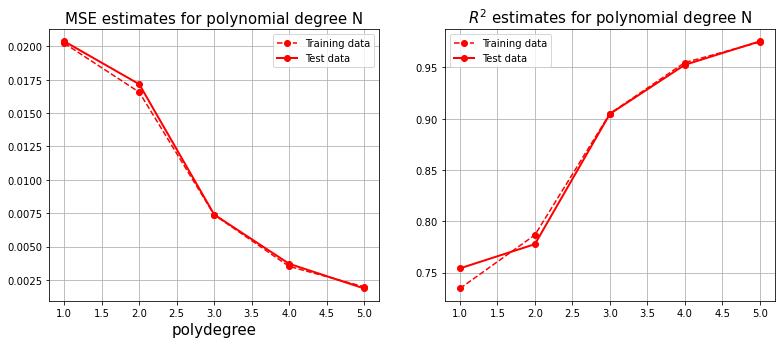

In [9]:
#plotting MSE and R2 as function of polynomial degree
fig = plt.figure(figsize = (13, 5)) 
plt.subplot(1, 2, 1)
plt.title('MSE estimates for polynomial degree N', fontsize = 15)
plt.plot(polydegree, MSE_train, 'r--', marker = 'o', label = 'Training data')
plt.plot(polydegree, MSE_test, 'r', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('polydegree', fontsize = 15)
plt.grid(1); plt.legend()


plt.subplot(1, 2, 2)
plt.title('$R^2$ estimates for polynomial degree N', fontsize = 15)
plt.plot(polydegree, R2_train, 'r--', marker = 'o', label = 'Training data')
plt.plot(polydegree, R2_test, 'r', marker = 'o', label = 'Test data', linewidth = 2)
# plt.xlabel('polydegree', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

#### Plotting the variance of beta's

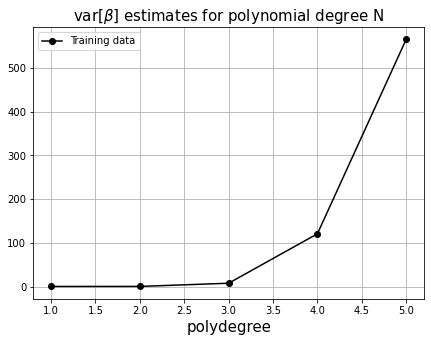

In [10]:
fig = plt.figure(figsize = (7, 5))
plt.title('var[$\\beta$] estimates for polynomial degree N', fontsize = 15)
plt.plot(polydegree, var_B, 'k', marker = 'o', label = 'Training data')
#plt.plot(N_, var_B_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('polydegree', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

Can clearly see that variance of beta increases exponentially with every degree. You can also show this by scaling it logarithmicly, then you should get just a line.


Why haven't we scaled or centered the data. This is because our data is scaled already. In a way. Our data x and y goes only from 0 and 1, and this is the most optimal scaling range as you can get. However, for z values, we also do not have very large fluctuations. If we would have large fluctuations, let's say values from -1000 to 1000, the study of errors would become challanging, since we wouldn't know how to determine if for example an error of order 10 is good or bad. If we would get such data with these fluctuations, it would be simpler to scale the data, and study the relative errors of our predictions. 

## Bias-variance trade-off for OLS

First, they asks us make similar plot as this

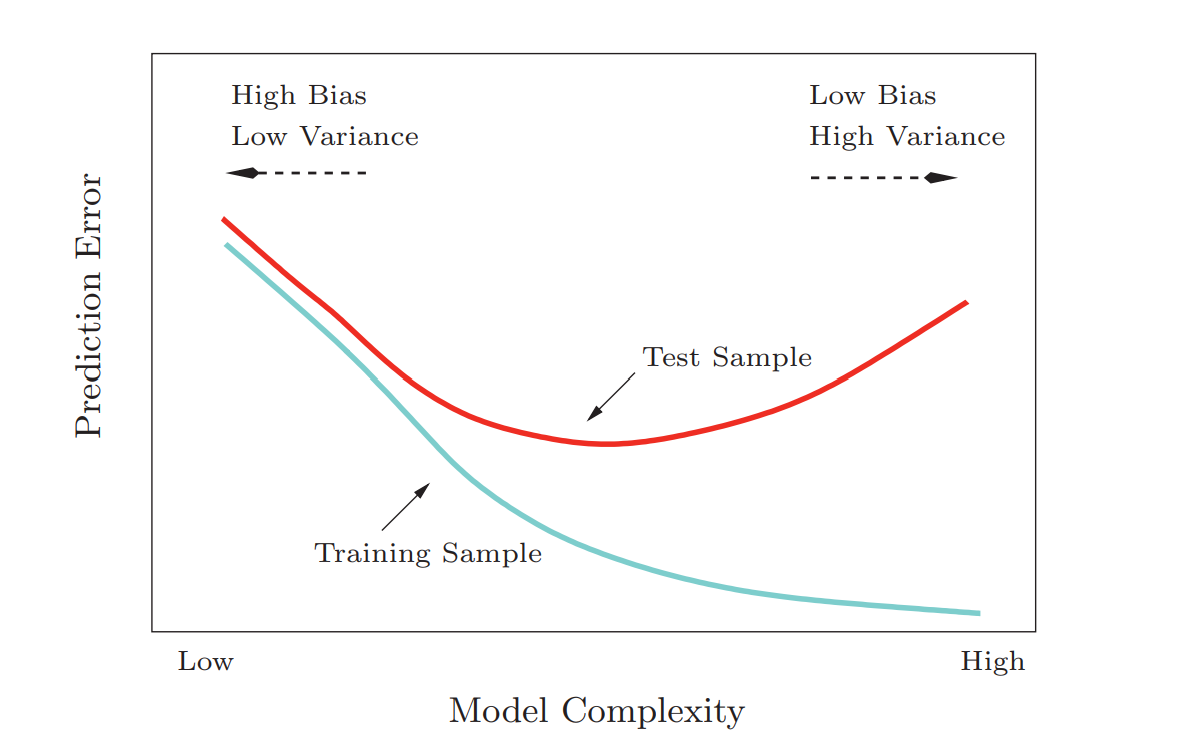

It is the the same as we did in previous task. We can now upgrade it to plot for even more degrees of polys, not only for 5. But is it nescessery? YES it is! The difference is that we will do with bootstrap method.

After this, we are asked to perform a bias-variance analysis by studying the MSE value as function of the complexity of our model. 

Remember when doing this, split the data into test and train sets with bootstrap resampling method. 

But first, what is actually bootsrap resampling method. Well, the algorithm of resampling goes as following:

    1. We have a set of data points x with n-number of values
    2. We take m random number of values from this set, and form new set x'.
    3. We compute beta specifically for this x'.
    4. We do it k times and find relative frequency of these beta's and estimate p(t).

In [25]:

def bootstrap(X, z, bootstrap_n):
    beta = np.zeros([bootstrap_n, np.shape(X)[1]])
    n_samples = np.shape(X)[0] - 10
    for i in range(bootstrap_n):
        X_n, z_n = resample(X, z, replace=True, n_samples=None)
        beta[i] = np.linalg.inv(X_n.T @ X_n) @ X_n.T @ z_n
    beta_bootstrapped = np.mean(beta, axis=0)
    
    return X_n, z_n, beta_bootstrapped

def bootstrap_ridge(X, z, bootstrap_n, lambd):
    beta = np.zeros([bootstrap_n, np.shape(X)[1]])
    n_samples = np.shape(X)[0] - 10
    I = np.eye(np.shape(X_train)[1],np.shape(X_train)[1])
    for i in range(bootstrap_n):
        X_n, z_n = resample(X, z, replace=True, n_samples=None)
        beta[i] = np.linalg.inv(X_n.T @ X_n + lambd*I) @ X_n.T @ z_n
    beta_bootstrapped = np.mean(beta, axis=0)
    
    return X_n, z_n, beta_bootstrapped

# for i in range(20):
#     X = create_X(x_, y_, n = i)
#     X_n, z_n, beta_bootstrapped = bootstrap(X, np.ravel(z),10)
#     z_p = X @ beta_bootstrapped
#     z_p_matrix = z_p.reshape(100,100)
    
#     error = MSE(np.ravel(np.ravel(z)), z_p)

#     plotting3D(x_, y_, z_p_matrix, f"error:{error}, {i}")
    


Now we have a matrix of beta's. Every row is an estimated beta array for every loop. We want to find the mean value of all calculated betas, so we take all values of the column, and find mean value of it. We have done it in the bootstrap function.

Now, we want to make this complexity model plot

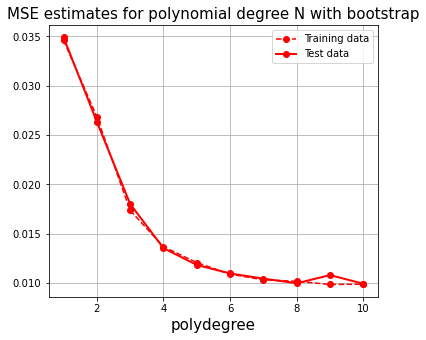

In [15]:
max_degrees = 10
bootstrap_n = 100
MSE_train = np.zeros(max_degrees)
MSE_test = np.zeros(max_degrees)
polydegree = np.zeros(max_degrees)

for i in range(1, max_degrees+1):
    X = create_X(x_, y_, n = i)
    X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z_noise), test_size=0.2)
    
    X_n, z_n, beta_bootstrapped = bootstrap(X_train, z_train,5)
    z_train_predict = X_train @ beta_bootstrapped
    z_test_predict = X_test @ beta_bootstrapped

    
    MSE_train[i-1] = MSE(z_train, z_train_predict)
    MSE_test[i-1] = MSE(z_test, z_test_predict)
    polydegree[i-1] = int(i)


fig = plt.figure(figsize = (13, 5)) 
plt.subplot(1, 2, 1)
plt.title('MSE estimates for polynomial degree N with bootstrap', fontsize = 15)
plt.plot(polydegree, MSE_train, 'r--', marker = 'o', label = 'Training data')
plt.plot(polydegree, MSE_test, 'r', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('polydegree', fontsize = 15)
plt.grid(1); plt.legend()
plt.show()

### Simple Ridge model for degree n = 5

Here, we need to rescale the data

The most optimal lambda is 0.7055
with MSE value of 0.024095348901697962


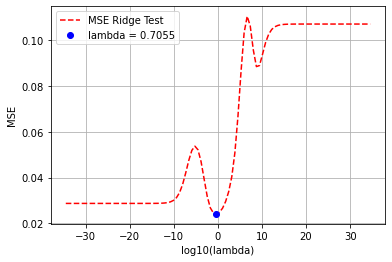

In [16]:
X = create_X(x_, y_, n = 5)

#Split this data into test and train sets:
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z_noise), test_size=0.2, shuffle=True)

I = np.eye(np.shape(X_train)[1],np.shape(X_train)[1]) #defining identity matrix

nlambdas = 100 #number of lambdas
MSEPredict = np.zeros(nlambdas)
lambdas = np.logspace(-15,15, nlambdas)

X_train_scale = X_train - np.mean(X_train)
z_train_scale = z_train - np.mean(z_train)


for i in range(nlambdas):
    RidgeBeta = np.linalg.inv(X_train_scale.T@X_train_scale + lambdas[i]*I) @ X_train_scale.T @ z_train_scale
    X_test_unscale = X_test - np.mean(X_train)
    zpredictRidge = X_test @ RidgeBeta + np.mean(z_train)
    MSEPredict[i] = MSE(np.ravel(z_test), zpredictRidge)

#find lowest value of lambda
min_value_index = np.where(MSEPredict == np.min(MSEPredict))
formatted_lambda = ("{:.4f}".format(lambdas[min_value_index][0]))
print(f"The most optimal lambda is {formatted_lambda}")
print(f"with MSE value of {MSEPredict[min_value_index][0]}")


plt.figure()
plt.plot(np.log(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
plt.plot(np.log(lambdas[min_value_index][0]), MSEPredict[min_value_index][0], 'bo', label = f"lambda = {formatted_lambda}")

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.grid(1)
plt.legend()
plt.show()

We clearly see that most optimal lambda goes to zero. Since Ridge-regression is just a tweak to OLS, and we see that this tweak has to be zero, we can conclude that OLS is a good approximation. 

The reason for this might be because of low noise in our data. If we would increase the noise, this lambda could be different.

OOPS OOPS, its not always zero, sometimes its 0.7055! Do analysis for this

In [26]:
#Let us use this lambda
lambd = 0.7005


X_nr, z_nr, betaridge = bootstrap_ridge(X_train, z_train, bootstrap_n = 100, lambd = 0.7005)

maxdegree = 10
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(maxdegree)